In [1]:
import numpy as np
import json
import pandas as pd


from matrix_class import ProteinMatrix
from matrix_class import SubMatrix
from cluster_class import AllClusters
from degreelist_class import DegreeList


from connected_components_utils import *
from analysis_utils import *

from func_e.FUNC_E import FUNC_E # import the class
import func_e.vocabs.all as vocabs

In [2]:
dream3_cluster_dict_file = "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json"
dict_of_clusters = {}
# # convert actual cluster file to a dictionary!!
with open(dream3_cluster_dict_file,"r") as cluster_dict_file:
    dict_of_clusters = json.load(cluster_dict_file)

In [3]:
matrix, clusters, degreelist = initialize_matrix_clusters_degreelist("../data/networks/DREAM_files/dream_3.txt", "../data/results/DREAM-3-cc/d3_5_100.json-cluster.json")

In [4]:
genomic_background_filepath = '../data/testing_data/protein_list.txt'
all_go_terms = vocabs.getTerms(['GO'])
term_mapping_filepath = 'term_mapping.txt'
create_term_mapping_list('../data/go-results/dream_3_go_results.tsv', term_mapping_filepath)

In [5]:
og_clusters_querylist_path = 'original_querylist.txt'
print_querylist_of_clusters_to_file(clusters, clusters.get_all_cluster_labels(), query_filepath=og_clusters_querylist_path)


original_fe = FUNC_E()
original_fe.importFiles({
    'background': genomic_background_filepath, 
    'terms2features': term_mapping_filepath })
original_fe.setTerms(all_go_terms)
original_fe.setEnrichmentSettings({'ecut': 0.01})

original_fe.importFiles({'query': og_clusters_querylist_path })
original_fe.run(cluster=False)

get_all_cluster_labels fxn has not been tested


/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [6]:
original_df = original_fe.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df['Module'] = original_df['Module'] + ' ' + original_df['Term']
original_df.drop('Term', axis=1, inplace=True)

### Now: will create different sets of proteins to add back etc

#### take 1: clusters that are pretty well connected

step 1: find qualifying proteins and clusters with very strict cutoff, and initialize clusters

In [7]:
qualifying_clusters_1, qualifying_proteins_1 = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio=.90, min_components_that_protein_connects=3, find_clusters_that_are_MORE_connected=True)

In [8]:
print(qualifying_clusters_1)
print(qualifying_proteins_1)

[25, 152, 161, 185]
{25: ['AKT1', 'SRC'], 152: ['PPM1A', 'PPP2CA', 'CDK2', 'GSK3B', 'MAPK3', 'CSNK2A1', 'PRKACA', 'SRC'], 161: ['SNCA', 'LRP6', 'RPS6KA1', 'NFE2L2', 'ESR1', 'GRB2', 'PLK1', 'STAT3', 'MAPK8', 'ABL1', 'MAPK14', 'GSK3B', 'TP53', 'AKT1', 'CSNK2A1', 'CDK1', 'PRKCA'], 185: ['TSC1', 'IKBKB']}


In [9]:
# new_clusters_1 = AllClusters(protein_to_cluster_dict=dict_of_clusters)
# print(new_clusters_1.get_cluster_proteins(152))
# print(clusters.get_cluster_proteins(152))


# print("")
# new_clusters_1 = modified_clusters(new_clusters_1, qualifying_proteins_1)
# print(new_clusters_1.get_cluster_proteins(152))
#TODO: ERRORRRRR original clusters get their cluster proteins updated as well. 


In [10]:
# from analysis_utils import print_both_querylists_to_files
# from analysis_utils import get_initialized_fe

step 2: run functional enrichment
    a. create og and new querylists
    b. create a comparison and new functional enrichment with querylists as input
    c. run both functional enrichments

In [11]:
original_clusters_querylist_1 = 'og_querylist_1.txt'
updated_clusters_querylist_1 = 'new_querylist_1.txt'

In [12]:
# original:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_1,original_clusters_querylist_1)

# clusters with added proteins:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_1, updated_clusters_querylist_1, qualifying_proteins_1)

In [13]:
original_fe_1 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_1 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)


In [ ]:
original_fe_1.importFiles({'query': original_clusters_querylist_1 })
original_fe_1.run(cluster=False)

updated_fe_1.importFiles({'query': updated_clusters_querylist_1 })
updated_fe_1.run(cluster=False)

step 3: from functional enrichment, assemble data/p-values
    a. get original and updated pvals
    b. combine in a single dataframe

In [15]:
original_df_1 = original_fe_1.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df_1['Module'] = original_df_1['Module'] + ' ' + original_df_1['Term']
original_df_1.drop('Term', axis=1, inplace=True)

In [16]:
original_df_1


,Module,Fishers_pvalue
0,cluster_161 GO:0030175,0.002023
1,cluster_161 GO:0032465,0.007341
2,cluster_185 GO:0016241,0.007339
3,cluster_185 GO:0016485,0.005832
4,cluster_185 GO:0030216,0.004486
5,cluster_185 GO:0055038,0.007339
6,cluster_185 GO:0070507,0.002297
7,cluster_185 GO:0072659,0.001876
8,cluster_25 GO:0007346,0.007487
9,cluster_25 GO:0032728,0.005714


In [17]:
updated_df_1 = updated_fe_1.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df_1['Module'] = updated_df_1['Module'] + ' ' + updated_df_1['Term']
updated_df_1.drop('Term', axis=1, inplace=True)
updated_df_1.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)

In [18]:
# updated_df_1

In [19]:
results_df_1 = pd.merge(original_df_1, updated_df_1, on=['Module'], how='outer')
# results_df_1

step 4: display results in a graph

In [20]:
import matplotlib.pyplot as plt

In [21]:
# print(results_df_1)

<AxesSubplot:xlabel='Module'>

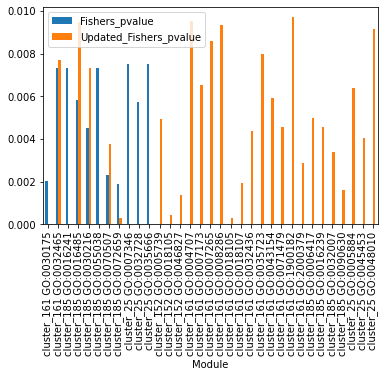

In [22]:
results_df_1.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

this graph ^ is interesting bc it shows that p-values increase (less significant). this shows that maybe we are adding proteins to the wrong clusters. it will be interesting to go back and tweak the functions and see how adding different things affects everything

In [23]:
changes_df_1 = (results_df_1.copy()).dropna(axis=0)

<AxesSubplot:xlabel='Module'>

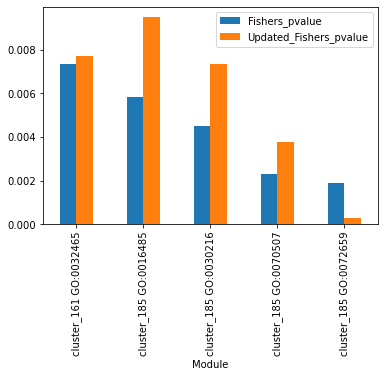

In [24]:
changes_df_1.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

^ this graph too, bc ur just adding proteins to clusters and then the proteins aren't actually enhancing the functional enrichment of the clusters

#### Take 2: clusters that are very unconnected
 NOW! will find clusters that were previously not qualifying. the qualifying clusters will now be those that are super disconnected!

In [25]:
# am now changing this function to find highly unconnectged cllsters!
def find_clusters_and_proteins_together(matrix: ProteinMatrix, clusters: AllClusters, degreelist: DegreeList, cluster_ratio: float = .5, cluster_constant: int = 0, protein_ratio: float = .05, find_clusters_that_are_MORE_connected: bool = False, protein_constant: int = 2, min_components_that_protein_connects: int = -1, max_degree: int = 500) -> list() and dict():
    """
    function is a version of find_clusters_that_match_criteria, that, once it finds the cluster, finds corresponding proteins at the same time so that the submatrix doesn't need to be reconstructed

    Parameters: 
        matrix - a ProteinMatrix of all protein interactions
        clusters - an AllClusters containing proteins grouped into clusters
        cluster_ratio and cluster_constant - used together to determine which clusters qualify, with the output of the function being cluster_ratio * input + cluster_constant
        TODO: remaining parameters
    Purpose:    determines clusters that are mostly highly connected, then 
                determines which proteins that, when added to the cluster, will 
                increase it's connectedness
    Returns:    a list containing the numbers of the clusters that qualify, and 
                a dictionary linking each cluster, to a list of the qualifying 
                proteins
    TODO: a cluster will qualify if -> IT IS HIGHLY UNCONNECTED
    """
    
    cluster_nums_that_qualify = list()
    qualifying_proteins_dict = dict()

    for cluster_num in clusters.get_all_clusters():
        # create a submatrix out of the proteins in the cluster
        submatrix = SubMatrix(clusters.get_cluster_proteins(cluster_num), matrix)
        num_components, labels = submatrix.get_num_components_and_labels()
        # print(f"num components is {num_components}. num proteins is {len(submatrix.get_list_of_proteins())}")
        if (num_components >= (cluster_ratio * len(submatrix.get_list_of_proteins()) + cluster_constant)) != find_clusters_that_are_MORE_connected:

            # add cluster to list showing that it qualifies, 
            cluster_nums_that_qualify.append(cluster_num)

            # then do analysis on the cluster -> create a list of qualifying proteins
            qualifying_proteins = qualifying_proteins_using_submatrix(cluster_num, submatrix, clusters, degreelist, ratio=protein_ratio, constant=protein_constant, min_components_that_protein_connects=min_components_that_protein_connects, max_degree=max_degree)

            if qualifying_proteins: # not empty
                qualifying_proteins_dict[cluster_num] = qualifying_proteins
            


    return cluster_nums_that_qualify, qualifying_proteins_dict



In [26]:
qualifying_clusters_2, qualifying_proteins_2 = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio = 0.95, cluster_constant = 2, protein_constant=2, protein_ratio=.05)

In [27]:
# print(qualifying_proteins_2)
# print(qualifying_clusters_2)

now do functional enrichment:

In [28]:
original_clusters_querylist_2 = 'og_querylist_2.txt'
updated_clusters_querylist_2 = 'new_querylist_2.txt'

In [40]:
# original:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_2,original_clusters_querylist_2)

# clusters with added proteins:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_2, updated_clusters_querylist_2, qualifying_proteins_2)

In [30]:
original_fe_2 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_2 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

In [31]:
original_fe_2.importFiles({'query': original_clusters_querylist_2 })
original_fe_2.run(cluster=False)

updated_fe_2.importFiles({'query': updated_clusters_querylist_2 })
updated_fe_2.run(cluster=False)

/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [32]:
original_df_2 = original_fe_2.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df_2['Module'] = original_df_2['Module'] + ' ' + original_df_2['Term']
original_df_2.drop('Term', axis=1, inplace=True)

In [33]:
updated_df_2 = updated_fe_2.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df_2['Module'] = updated_df_2['Module'] + ' ' + updated_df_2['Term']
updated_df_2.drop('Term', axis=1, inplace=True)
updated_df_2.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)

In [34]:
results_df_2 = pd.merge(original_df_2, updated_df_2, on=['Module'], how='outer')
# results_df_2

<AxesSubplot:xlabel='Module'>

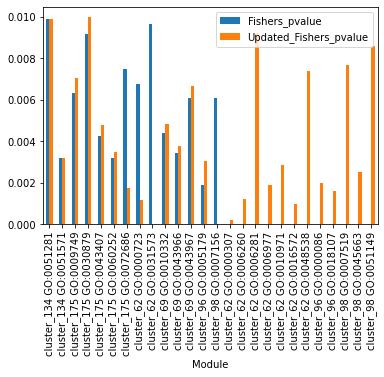

In [35]:
results_df_2.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

<AxesSubplot:xlabel='Module'>

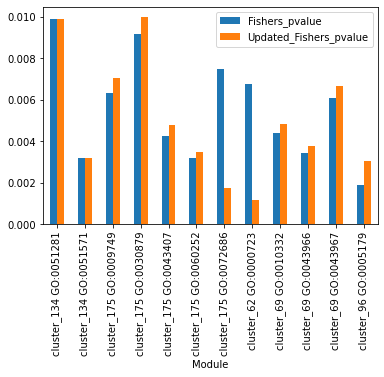

In [36]:
changes_df_2 = (results_df_2.copy()).dropna(axis=0)
changes_df_2.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

another interesting thing is that when proteins are added, WAY more significant pvalues show up compared to how many are lost when the proteins are added, however i don;t know if thats bc the proteins that are being added are all in the same group / type, or if they are are highlighting something already in the clusters

it seems like some of the go terms that are now enriched are similar across clusters -> i would assume that the proteins being added back are similar/the same accross clusters and therefore interact with many clusters (maybe signalling or smth)

#### Take 2b: the same unconnected clusters, but only adding 1 protein back in for each cluster
NOW will get results for the same highly unconnected clusters, but only adding one protein back in. 

In [63]:
qualifying_proteins_2_b = dict()
for key in qualifying_proteins_2:
    qualifying_proteins_2_b[key] = [qualifying_proteins_2[key][0]]

qualifying_proteins_2_b

{62: ['ATM'], 69: ['PRKCA'], 96: ['CSNK2A1'], 98: ['MAPK14'], 175: ['CDK1']}

In [64]:
def print_querylist_of_clusters_to_file(clusters: AllClusters, clusters_to_print: list(), query_filepath: str = "querylist.txt", proteins_to_add: dict() = dict()):
    """
    clusters_to_print -> specify a list of which clusters to print
    TODO
    proteins_to_add -> dictionary containing key: clusternum and value: list of proteins to add to that cluster
    """
    output_file = open(query_filepath, 'w')

    for cluster_num in clusters_to_print:
        for protein in clusters.get_cluster_proteins(cluster_num):
            output_file.write(f"{protein}\tcluster_{cluster_num}\n")
    
    if proteins_to_add: # dict not empty -> dict contains 
        for cluster_num in proteins_to_add: 
            for protein in proteins_to_add[cluster_num]: 
                output_file.write(f"{protein}\tcluster_{cluster_num}\n")

    output_file.close()

In [65]:
updated_clusters_querylist_2_b = 'new_querylist_2_b.txt' # the new querylist has an issue
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_2, updated_clusters_querylist_2_b, qualifying_proteins_2_b)
updated_fe_2_b = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

In [66]:
updated_fe_2_b.importFiles({'query': updated_clusters_querylist_2_b })
updated_fe_2_b.run(cluster=False)

/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [67]:
updated_df_2_b = updated_fe_2_b.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df_2_b['Module'] = updated_df_2_b['Module'] + ' ' + updated_df_2_b['Term']
updated_df_2_b.drop('Term', axis=1, inplace=True)
updated_df_2_b.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)

<AxesSubplot:xlabel='Module'>

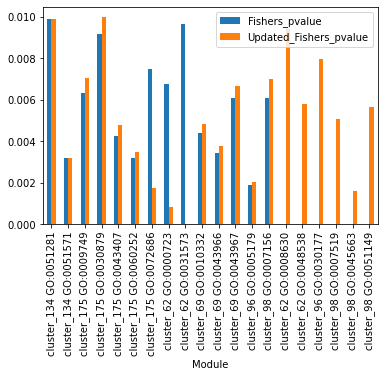

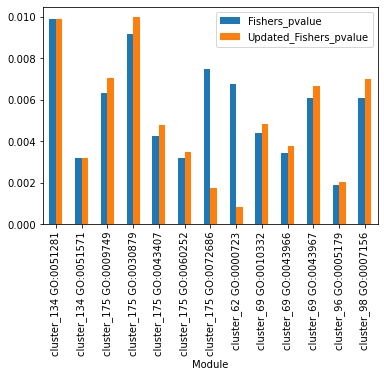

In [69]:
results_df_2_b = pd.merge(original_df_2, updated_df_2_b, on=['Module'], how='outer')
results_df_2_b.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")
changes_df_2_b = (results_df_2_b.copy()).dropna(axis=0)
changes_df_2_b.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

should i add the most connected protein? or the ???


what can the next step be?


#### Try 3: unconnected clusters, proteins that are VERY connected (this yields more clusters, but fewer proteins per cluster)

In [70]:
qualifying_clusters_3, qualifying_proteins_3 = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio = 0.90, protein_constant=1, protein_ratio=.1)

what we see below is that almost all clusters qualify, but for each cluster that qualifies, only a few have proteins that qualify. i want to do some stats on the sizes of the clusters that have qualifying proteins, vs the sizes of the clusters that dont

In [81]:
sizes_for_protein_clusters = list()
for cluster_num in qualifying_proteins_3.keys():
    sizes_for_protein_clusters.append(len(clusters.get_cluster_proteins(cluster_num)))

print(sum(sizes_for_protein_clusters)/len(sizes_for_protein_clusters))

16.928571428571427


In [82]:
sizes_for_protein_clusters = list()
for cluster_num in qualifying_clusters_3:
    sizes_for_protein_clusters.append(len(clusters.get_cluster_proteins(cluster_num)))

print(sum(sizes_for_protein_clusters)/len(sizes_for_protein_clusters))

23.369230769230768


In [71]:
print(qualifying_proteins_3)
print(qualifying_clusters_3)

{9: ['FASLG', 'CASP1', 'CREBBP', 'EP300', 'ABL1', 'ATM', 'MAPK14', 'TP53', 'MAPK3', 'MAPK1', 'SRC'], 10: ['NOTCH1'], 11: ['PRKACA'], 20: ['CHEK1', 'ATM'], 23: ['IKBKE', 'AR'], 26: ['PRKACA'], 27: ['ATM'], 28: ['TGFBR2'], 32: ['CSNK2B', 'CSNK2A1'], 33: ['ATM'], 38: ['PIK3R1'], 39: ['SRC'], 41: ['EGFR', 'AKT1', 'PRKCA', 'SRC'], 42: ['PRKCA'], 47: ['MAPK8'], 55: ['STAT1', 'CSNK2A1'], 61: ['GSK3B'], 65: ['CSNK2A1', 'SRC'], 66: ['TAB1', 'MAP4K1', 'BCL2L1', 'RAC1', 'SHC1', 'STAT3', 'TRAF6', 'PRKCA'], 72: ['RAC1', 'CHUK', 'PRKACA'], 74: ['STAT3', 'AKT1', 'PRKCA'], 78: ['SRC'], 79: ['SMAD3'], 81: ['CDK2'], 84: ['MAPK1'], 85: ['MAPK1'], 87: ['CSNK2A1'], 89: ['BACE1', 'MAPT', 'FYN', 'CTNNB1', 'GSK3B', 'TP53'], 91: ['MAP3K5'], 93: ['PRKAA2'], 98: ['CDK1'], 100: ['PRKCA'], 106: ['PRKACA'], 107: ['EGFR', 'SRC'], 110: ['PRKACA'], 111: ['CDK5', 'GSK3B'], 112: ['PLK1', 'GSK3B'], 114: ['MAPK1'], 115: ['PRKCA'], 117: ['CSNK2A1'], 118: ['PRKACA'], 119: ['AKT1'], 122: ['MAPK1'], 123: ['MAPK14', 'MAPK1'], 

In [72]:
original_clusters_querylist_3 = 'og_querylist_3.txt'
updated_clusters_querylist_3 = 'new_querylist_3.txt'

# original:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_3,original_clusters_querylist_3)

# clusters with added proteins:
print_querylist_of_clusters_to_file(clusters, qualifying_clusters_3, updated_clusters_querylist_3, qualifying_proteins_3)

In [73]:
original_fe_3 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_3 = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

In [74]:
original_fe_3.importFiles({'query': original_clusters_querylist_3 })
original_fe_3.run(cluster=False)

updated_fe_3.importFiles({'query': updated_clusters_querylist_3 })
updated_fe_3.run(cluster=False)

/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modResults = modResults.append({
/Users/charlotte/miniconda3/envs/diamonds/lib/python3.10/site-packages/func_e/FUNC_E.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [75]:
original_df_3 = original_fe_3.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()
original_df_3['Module'] = original_df_3['Module'] + ' ' + original_df_3['Term']
original_df_3.drop('Term', axis=1, inplace=True)

In [76]:
updated_df_3 = updated_fe_3.enrichment[['Module', 'Term', 'Fishers_pvalue']].copy()

updated_df_3['Module'] = updated_df_3['Module'] + ' ' + updated_df_3['Term']
updated_df_3.drop('Term', axis=1, inplace=True)
updated_df_3.rename(columns = {'Fishers_pvalue':'Updated_Fishers_pvalue'}, inplace = True)

<AxesSubplot:xlabel='Module'>

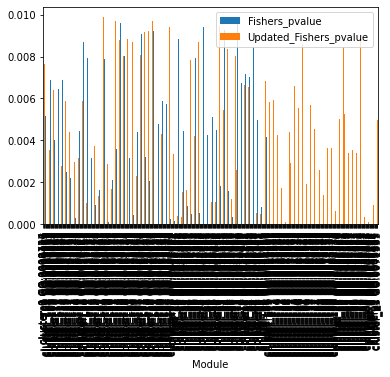

In [77]:
results_df_3 = pd.merge(original_df_3, updated_df_3, on=['Module'], how='outer')
results_df_3.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")

<AxesSubplot:xlabel='Module'>

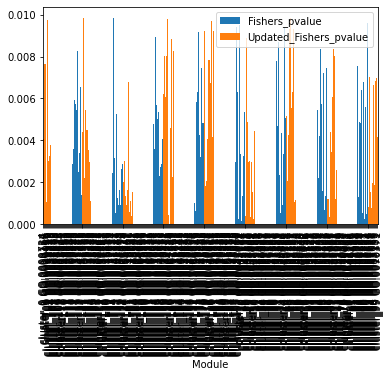

In [78]:
changes_df_3 = (results_df_3.copy()).dropna(axis=0)
changes_df_3.plot(x="Module", y=["Fishers_pvalue", "Updated_Fishers_pvalue"], kind="bar")